#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/kt/projects_kt/project_6/6/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten,Dropout, BatchNormalization, MaxPooling1D
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


####product03

In [ ]:
from datetime import timedelta
import holidays
def make_dataset(Product_ID):

    # 1. 기본 데이터 준비
    leadTime = products.loc[products['Product_ID']==Product_ID, 'LeadTime'].values[0]
    temp1 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
    temp2 = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
    temp3 = pd.merge(temp1, temp2)
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace = True)

    # 2. feature engineering
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.weekday # 요일 추출 (0: 월요일, 6: 일요일)
    temp3['Month'] = temp3['Date'].dt.month
    temp3['Day']=temp3['Date'].dt.day

    # 2일뒤 요일
    temp3['Date_2']=temp3['Date']+timedelta(2)
    temp3['Day+2']=temp3['Date_2'].dt.day
    temp3['Weekday+2']=temp3['Date_2'].dt.weekday

    temp3['Qty_1ago'] = temp3['Qty'].shift(1) #1일전 매출
    temp3['Qty_2ago'] = temp3['Qty'].shift(2) #2일전 매출
    temp3['Qty_last week'] = temp3['Qty'].shift(7) #일주일전 매출

    # 평균 판매량(7일, 14일)
    temp3['MA_7'] = temp3['Qty'].rolling(window=7).mean()
    temp3['MA_14'] = temp3['Qty'].rolling(window=14).mean()

    # 판매량 변화율
    temp3['Qty_diff_1'] = temp3['Qty'].diff(1)

    # 미국 공휴일 인스턴스 생성
    us_holidays = holidays.US()
    # 미국 공휴일 여부 확인 (1: 공휴일, 0: 비공휴일)
    temp3['holiday'] = temp3['Date'].apply(lambda x: 1 if x in us_holidays else 0)

    # 주말
    temp3['weekend']=np.where(temp3['WeekDay']>=5,1,0)

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    # 2.4 oil price MA14
    # 결측치를 이전값과 이후값의 평균으로 채우기
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
    # 첫번째 또는 마지막 값이 결측치인 경우 이전/이후 값으로 채우기
    oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='ffill').fillna(method='bfill')

    temp3 = pd.merge(temp3, oil_price, how = 'left')
    temp3['WTI_Price'] = temp3['WTI_Price'].rolling(14, min_periods=1).mean()
    temp3.dropna(inplace = True)

    return temp3


In [ ]:
product03=make_dataset(3)
product03

,Date,Qty,CustomerCount,target,WeekDay,Month,Day,Date_2,Day+2,Weekday+2,...,Qty_2ago,Qty_last week,MA_7,MA_14,Qty_diff_1,holiday,weekend,Category_Qty,City_CustCount,WTI_Price
13,2014-01-15,6815.0,3872,7671.0,2,1,15,2014-01-17,17,4,...,7086.0,8800.0,8480.142857,9464.857143,994.0,0,0,7020.0,38896,92.8260
14,2014-01-16,7482.0,3781,13131.0,3,1,16,2014-01-18,18,5,...,5821.0,6606.0,8605.285714,9295.500000,667.0,0,0,7806.0,37616,92.6660
15,2014-01-17,7671.0,3953,13661.0,4,1,17,2014-01-19,19,6,...,6815.0,7051.0,8693.857143,9225.785714,189.0,0,0,8101.0,39421,92.6960
16,2014-01-18,13131.0,4950,7208.0,5,1,18,2014-01-20,20,0,...,7482.0,12599.0,8769.857143,9081.357143,5460.0,0,1,13874.0,47458,92.6960
17,2014-01-19,13661.0,4711,6778.0,6,1,19,2014-01-21,21,1,...,7671.0,13383.0,8809.571429,8942.428571,530.0,0,1,13661.0,46461,92.6960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,7856.0,3834,10208.0,2,2,22,2017-02-24,24,4,...,6004.0,7854.0,9534.857143,9913.714286,679.0,0,0,8118.0,38673,53.4275
1140,2017-02-23,8018.0,3955,12361.0,3,2,23,2017-02-25,25,5,...,7177.0,7829.0,9561.857143,9928.071429,162.0,0,0,8316.0,39881,53.5765
1141,2017-02-24,10208.0,4549,10108.0,4,2,24,2017-02-26,26,6,...,7856.0,9524.0,9659.571429,9879.571429,2190.0,0,0,10689.0,43170,53.5915
1142,2017-02-25,12361.0,4619,10006.0,5,2,25,2017-02-27,27,0,...,8018.0,16331.0,9092.428571,9785.357143,2153.0,0,1,13073.0,46801,53.5915


In [ ]:
from sklearn.preprocessing import StandardScaler
def preproc(data, y_scale = False) :
    x = product03.drop(['Date','Date_2', 'target'], axis = 1)
    y = product03.loc[:, 'target']

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x['Day'] = pd.Categorical(x['Day'] ,categories=range(1, 32),ordered=True)
    x = pd.get_dummies(x, columns = ['WeekDay','Month','Day'])

    # 스케일링
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 300, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

####product12

In [ ]:
target_sales = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 12)]
target_orders = orders.loc[orders['Store_ID'] == 44]
target_sales = pd.merge(target_sales, target_orders, how='inner', on=['Date', 'Store_ID'])
target_sales['Day'] = target_sales['Date'].dt.weekday
target_sales_data = target_sales.drop(['Store_ID', 'Product_ID'], axis=1)
target_sales_data['Qty_lag5'] = target_sales_data['Qty'].shift(5)
target_sales_data['CustomerCount_lag5'] = target_sales_data['CustomerCount'].shift(5)
target_sales_data['Day_lag5'] = target_sales_data['Day'].shift(-2)
target_sales_data['Qty_lag_2'] = target_sales_data['Qty'].shift(-2)
target_sales_data.drop([0, 1, 2, 3, 4], axis=0, inplace=True)
target_sales_data.dropna(axis=0, inplace=True)
target_sales_data['Day_lag5'] = target_sales_data['Day_lag5'].astype('int')
target_sales_data.reset_index(drop=True, inplace=True)
target_sales_data.head()

,Date,Qty,CustomerCount,Day,Qty_lag5,CustomerCount_lag5,Day_lag5,Qty_lag_2
0,2014-01-07,7124.0,3663,1,9647.0,4422.0,3,6731.0
1,2014-01-08,8683.0,4254,2,8879.0,4167.0,4,6992.0
2,2014-01-09,6731.0,3723,3,14188.0,5341.0,5,11224.0
3,2014-01-10,6992.0,4010,4,14490.0,5123.0,6,11536.0
4,2014-01-11,11224.0,5053,5,7614.0,3917.0,0,6948.0


####product42

In [ ]:
# 상품코드 리스트
product_codes = ['DB001','GA001','FM001']

# 상품코드별 데이터셋 구성
for code in product_codes:
    # 상품코드에 맞는 Product_ID 추출
    product_id = products[products['Product_Code']==code]['Product_ID'].values[0]

    # sales 데이터에서 필터링
    product_data = sales[sales['Product_ID'] == product_id]

## **(1) 상품 : 3 - Beverage**

In [ ]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc(product03, True)
y_min, y_max

(2853.0, 25413.0)

In [ ]:
# Beverage의 Product_ID 추출
beverage_id = products[products['Product_Code'] == 'DB001']['Product_ID'].values[0]

# sales 데이터에서 Beverage에 해당하는 데이터 필터링
beverage_data = sales[sales['Product_ID'] == beverage_id]

# 전처리 및 필요한 변수 추가 (예시로 Date 및 판매량 변수만 포함)
beverage_data = beverage_data[['Date', 'Qty']]  # 필요한 컬럼만 선택

# 데이터 저장
joblib.dump(beverage_data, path + 'DB001_dataset.pkl')
print("Beverage 데이터셋이 저장되었습니다.")

Beverage 데이터셋이 저장되었습니다.


## **(2) 상품 : 12 - Milk**

In [ ]:
# Milk의 Product_ID 추출
milk_id = products[products['Product_Code'] == 'GA001']['Product_ID'].values[0]

# sales 데이터에서 Milk에 해당하는 데이터 필터링
milk_data = sales[sales['Product_ID'] == milk_id]

# 전처리 및 필요한 변수 추가 (예시로 Date 및 판매량 변수만 포함)
milk_data = milk_data[['Date', 'Qty']]  # 필요한 컬럼만 선택

# 데이터 저장
joblib.dump(milk_data, path + 'GA001_dataset.pkl')
print("Milk 데이터셋이 저장되었습니다.")

Milk 데이터셋이 저장되었습니다.


## **(3) 상품 : 42 - Agricultural products**

In [ ]:
# 상품 번호로 직접 데이터셋을 추출하는 방식
# Agricultural products의 Product_ID가 주어진다고 가정
target_product_id = 42  # 예시로 Product_ID가 42인 경우

# sales 데이터에서 Agricultural products에 해당하고 매장 ID가 44인 데이터만 필터링
agricultural_data = sales[(sales['Product_ID'] == target_product_id) & (sales['Store_ID'] == 44)]

# 필요한 열만 선택
agricultural_data = agricultural_data[['Date', 'Qty']]

# 데이터 저장
joblib.dump(agricultural_data, path + f'{target_product_id}_store44_dataset.pkl')
print(f"Agricultural products (Product_ID: {target_product_id}, Store 44) 데이터셋이 저장되었습니다.")


Agricultural products (Product_ID: 42, Store 44) 데이터셋이 저장되었습니다.


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [ ]:
# 성능 평가 함수
def evaluate_model(y_true,pred,model_name,scaler):
    y_true_actual = scaler.inverse_transform(y_true.reshape(-1,1))
    pred_actual = scaler.inverse_transform(pred.reshape(-1,1))

    rmse = mean_squared_error(y_true_actual,pred_actual,squared=False)
    mae = mean_absolute_error(y_true_actual,pred_actual)
    non_zero_idx = y_true_actual != 0
    mape = np.mean(np.abs((y_true_actual[non_zero_idx] - pred_actual[non_zero_idx]) / y_true_actual[non_zero_idx])) * 100
    r2 = r2_score(y_true_actual,pred_actual)

    print(f'{model_name} - RMSE:{rmse} / MAE:{mae} / MAPE: {mape}% / R2-Score:{r2}')
    return rmse,mae,mape,r2

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [ ]:
#위에서 완료

### **2) 모델링**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(random_state=42)
dtr.fit(x_train,y_train)
y_pred=dtr.predict(x_val)
print(round(root_mean_squared_error(y_val,y_pred),3))
print(round(mean_absolute_error(y_val,y_pred),3))
print(round(mean_absolute_percentage_error(y_val,y_pred),3))
print(round(r2_score(y_val,y_pred),3))

0.094
0.071
0.233
0.576


In [ ]:
from sklearn.ensemble import RandomForestRegressor
dfr=RandomForestRegressor(random_state=42)
dfr.fit(x_train,y_train)
y_pred=dfr.predict(x_val)
print(round(root_mean_squared_error(y_val,y_pred),3))
print(round(mean_absolute_error(y_val,y_pred),3))
print(round(mean_absolute_percentage_error(y_val,y_pred),3))
print(round(r2_score(y_val,y_pred),3))

0.075
0.053
0.168
0.726


In [ ]:
from xgboost import XGBRegressor
xgb=XGBRegressor()
xgb.fit(x_train,y_train)
y_pred=xgb.predict(x_val)
print(round(root_mean_squared_error(y_val,y_pred),3))
print(round(mean_absolute_error(y_val,y_pred),3))
print(round(mean_absolute_percentage_error(y_val,y_pred),3))
print(round(r2_score(y_val,y_pred),3))

0.082
0.061
0.194
0.677


In [ ]:
from lightgbm import LGBMRegressor
lgb=LGBMRegressor()
lgb.fit(x_train,y_train)
y_pred=lgb.predict(x_val)
print(round(root_mean_squared_error(y_val,y_pred),3))
print(round(mean_absolute_error(y_val,y_pred),3))
print(round(mean_absolute_percentage_error(y_val,y_pred),3))
print(round(r2_score(y_val,y_pred),3))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 831, number of used features: 56
[LightGBM] [Info] Start training from score 0.236936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.083
0.061
0.197
0.665


In [ ]:
# 기본모델
clear_session()

nfeat = x_train.shape[1]

model03_00 = Sequential([Dense(1, input_shape = (nfeat, ) )])
model03_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

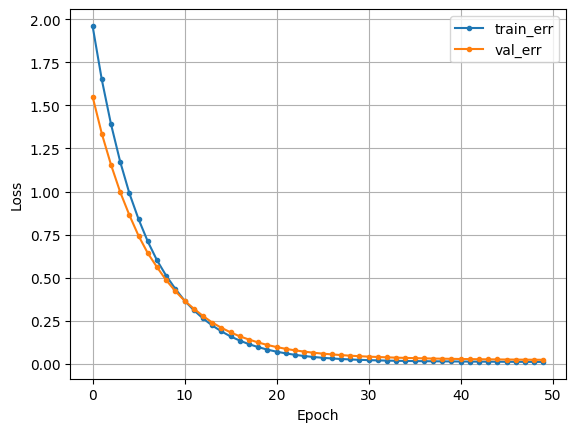

In [ ]:
model03_00.compile(optimizer = 'adam', loss = 'mse')
hist = model03_00.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_00.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE :  1837.310908203125
MAPE :  0.17302929196292746
R2 :  0.4204629263477996


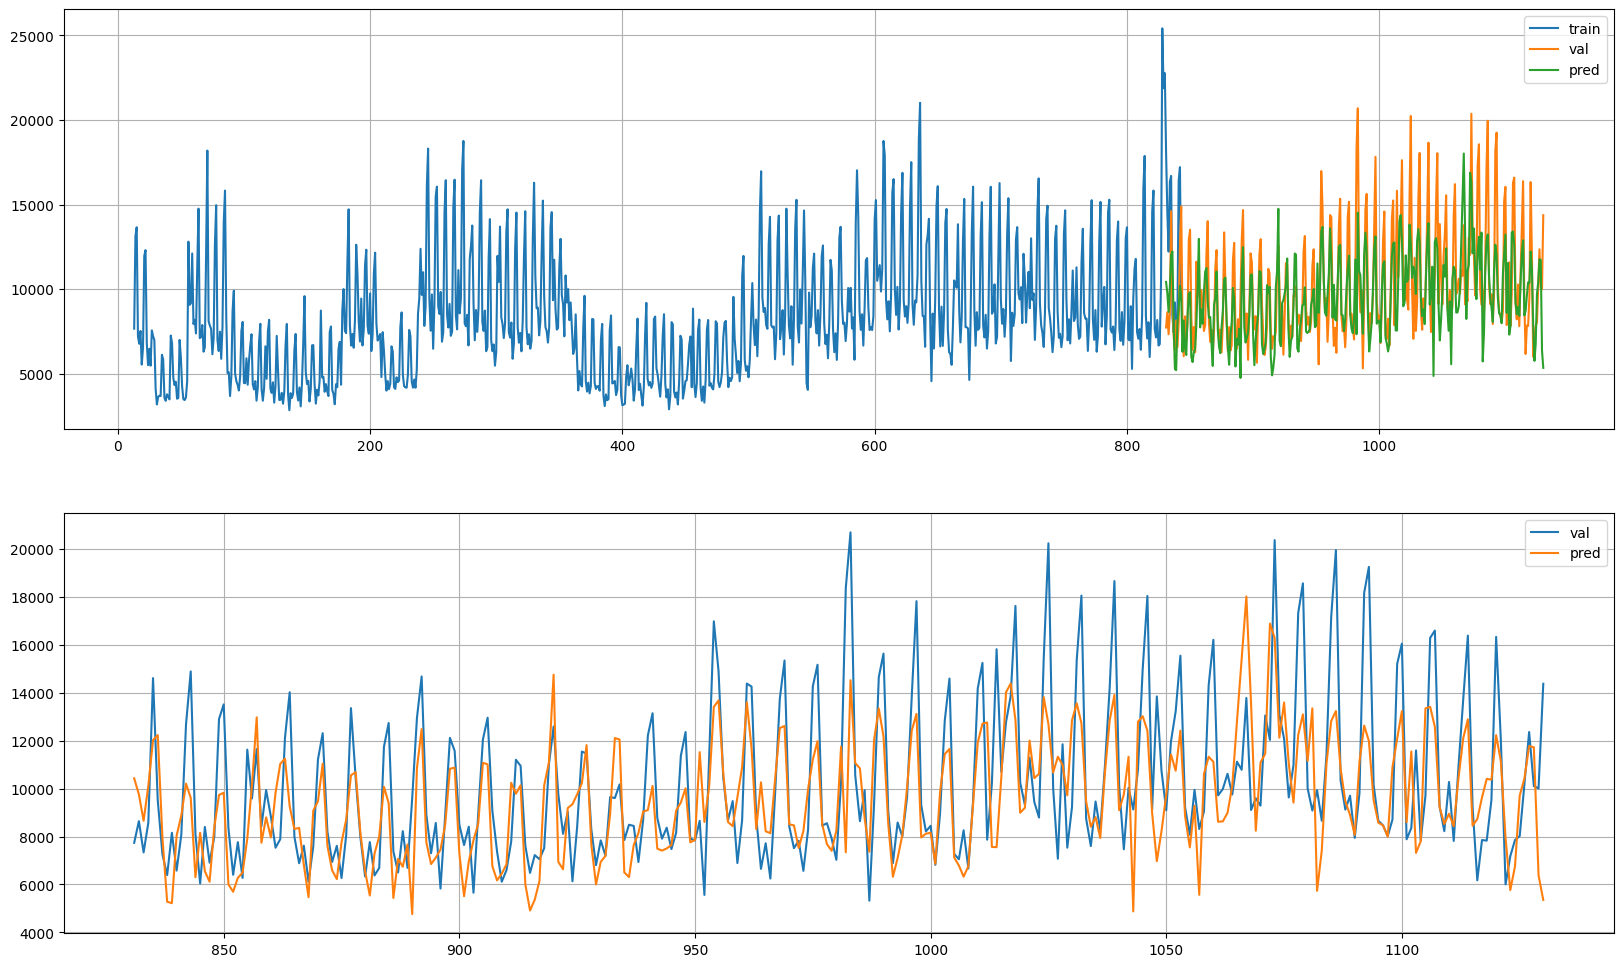

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [ ]:
target='Qty'
x = target_sales_data.drop([target, 'Date'], axis=1)
y = target_sales_data.loc[:, target]

y_min, y_max = min(y), max(y)
y_min, y_max

(4390.0, 37106.0)

In [ ]:
scaler = MinMaxScaler()

x = scaler.fit_transform(x)

In [ ]:
y = (y - y_min) / (y_max - y_min)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=60, random_state=42, shuffle=False)

### **2) 모델링**

In [ ]:
from tensorflow.keras.layers import Input
n_feat = x_train.shape[1]

model = Sequential([Input(shape=(n_feat,)),
                    Dense(1)])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=50, verbose=0).history

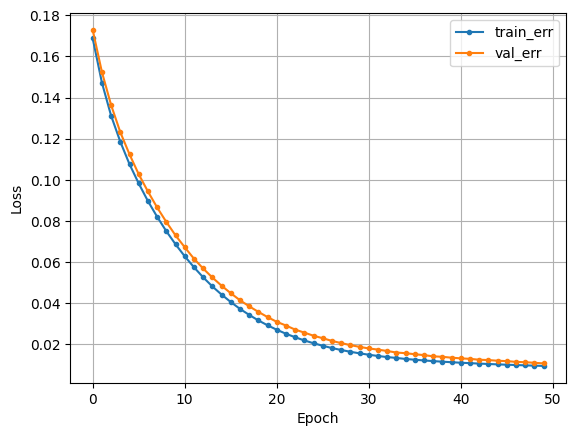

In [ ]:
dl_history_plot(hist)

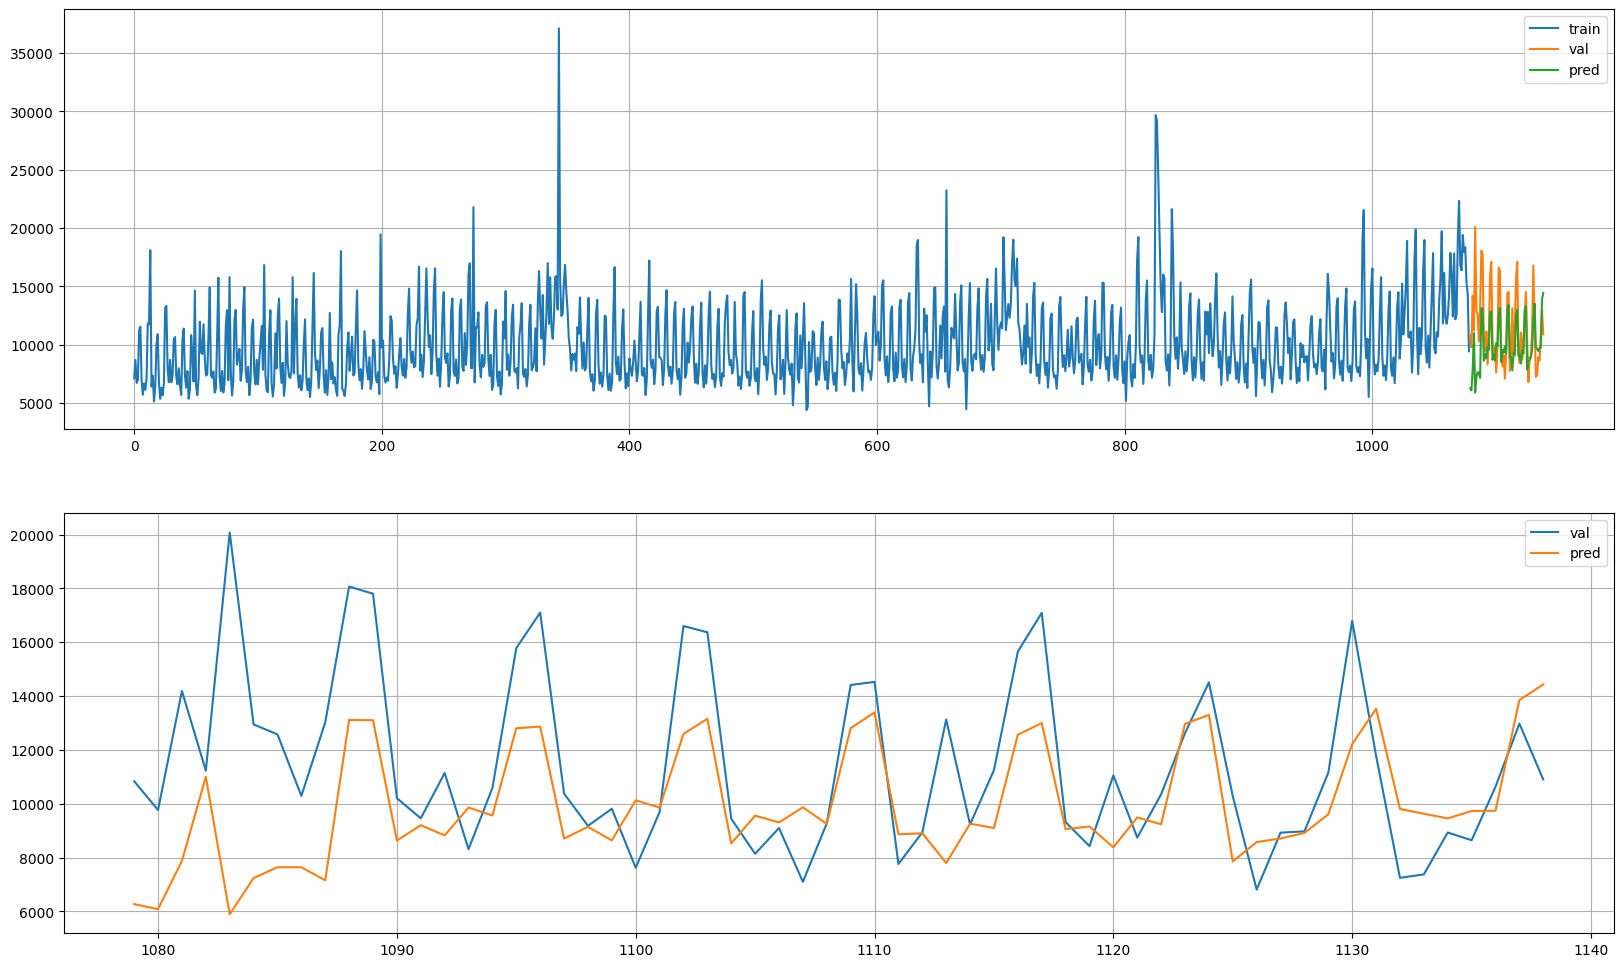

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min

plot_model_result(y_train2, y_valid2, y_pred)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [ ]:
# 데이터 로드
ap_data = joblib.load(path + '42_store44_dataset.pkl')

In [ ]:
# 스케일링
scaler = MinMaxScaler()
ap_data['Qty_scaled'] = scaler.fit_transform(ap_data[['Qty']]) # 2 차원 형태로 사용

In [ ]:
# 데이터 분할 (8:2)
train_size = int(len(ap_data) * 0.8)
train_data = ap_data[:train_size]
val_data = ap_data[train_size:]

x_train = np.array(train_data.index).reshape(-1,1)
y_train = train_data['Qty_scaled'].values
x_val = np.array(val_data.index).reshape(-1,1)
y_val = val_data['Qty_scaled'].values

### **2) 모델링**

In [ ]:
# Decision Tree Regressor 사용함
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(max_depth=5,random_state= 42)
dt_model.fit(x_train,y_train)
pred_dt = dt_model.predict(x_val)
evaluate_model(y_val,pred_dt,"Decision Tree", scaler)

Decision Tree - RMSE:57.76814945027315 / MAE:51.15367965367967 / MAPE: 54.11223816158538% / R2-Score:-3.0311494004667985


(57.76814945027315, 51.15367965367967, 54.11223816158538, -3.0311494004667985)

In [ ]:
# XGBoost Regressor
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(x_train,y_train)
pred_xgb = xgb_model.predict(x_val)
evaluate_model(y_val,pred_xgb,"XGBoost",scaler)

XGBoost - RMSE:57.88060034377513 / MAE:51.26872695988907 / MAPE: 54.224820345830906% / R2-Score:-3.0468586643782327


(57.88060034377513, 51.26872695988907, 54.224820345830906, -3.0468586643782327)

In [ ]:
# LgihtGBM
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(x_train,y_train)
pred_lgbm = lgbm_model.predict(x_val)
evaluate_model(y_val,pred_lgbm,"LightGBM",scaler)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 1
[LightGBM] [Info] Start training from score 0.447550
LightGBM - RMSE:49.96924650630223 / MAE:43.12084233024181 / MAPE: 46.19255290267701% / R2-Score:-2.0161822816264645


(49.96924650630223, 43.12084233024181, 46.19255290267701, -2.0161822816264645)

In [ ]:
# Dense Layer 모델
nn_model = Sequential()
nn_model.add(Dense(1, input_dim=x_train.shape[1]))  # 입력 차원을 지정

nn_model.compile(optimizer='adam', loss='mean_squared_error')

# 학습 - 검증 데이터를 추가하여 val_loss 추적
hist = nn_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_val, y_val), verbose=0)

# 예측
pred_nn = nn_model.predict(x_val).flatten()

# 성능 평가
evaluate_model(y_val, pred_nn, "Dense Layer Neural Net",scaler)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Dense Layer Neural Net - RMSE:164.46372625699595 / MAE:157.08075208787795 / MAPE: 157.43693151799926% / R2-Score:-31.673242393652167


(164.46372625699595,
 157.08075208787795,
 157.43693151799926,
 -31.673242393652167)

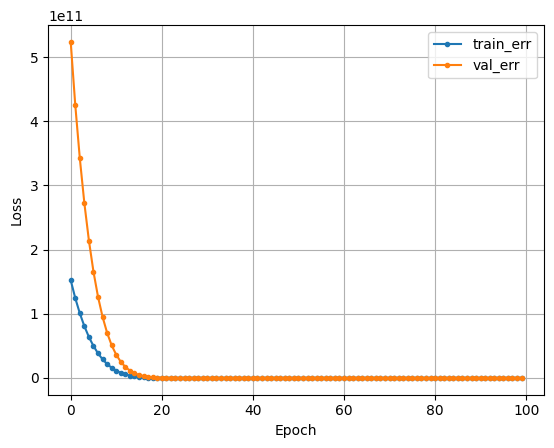

In [ ]:
dl_history_plot(hist.history)

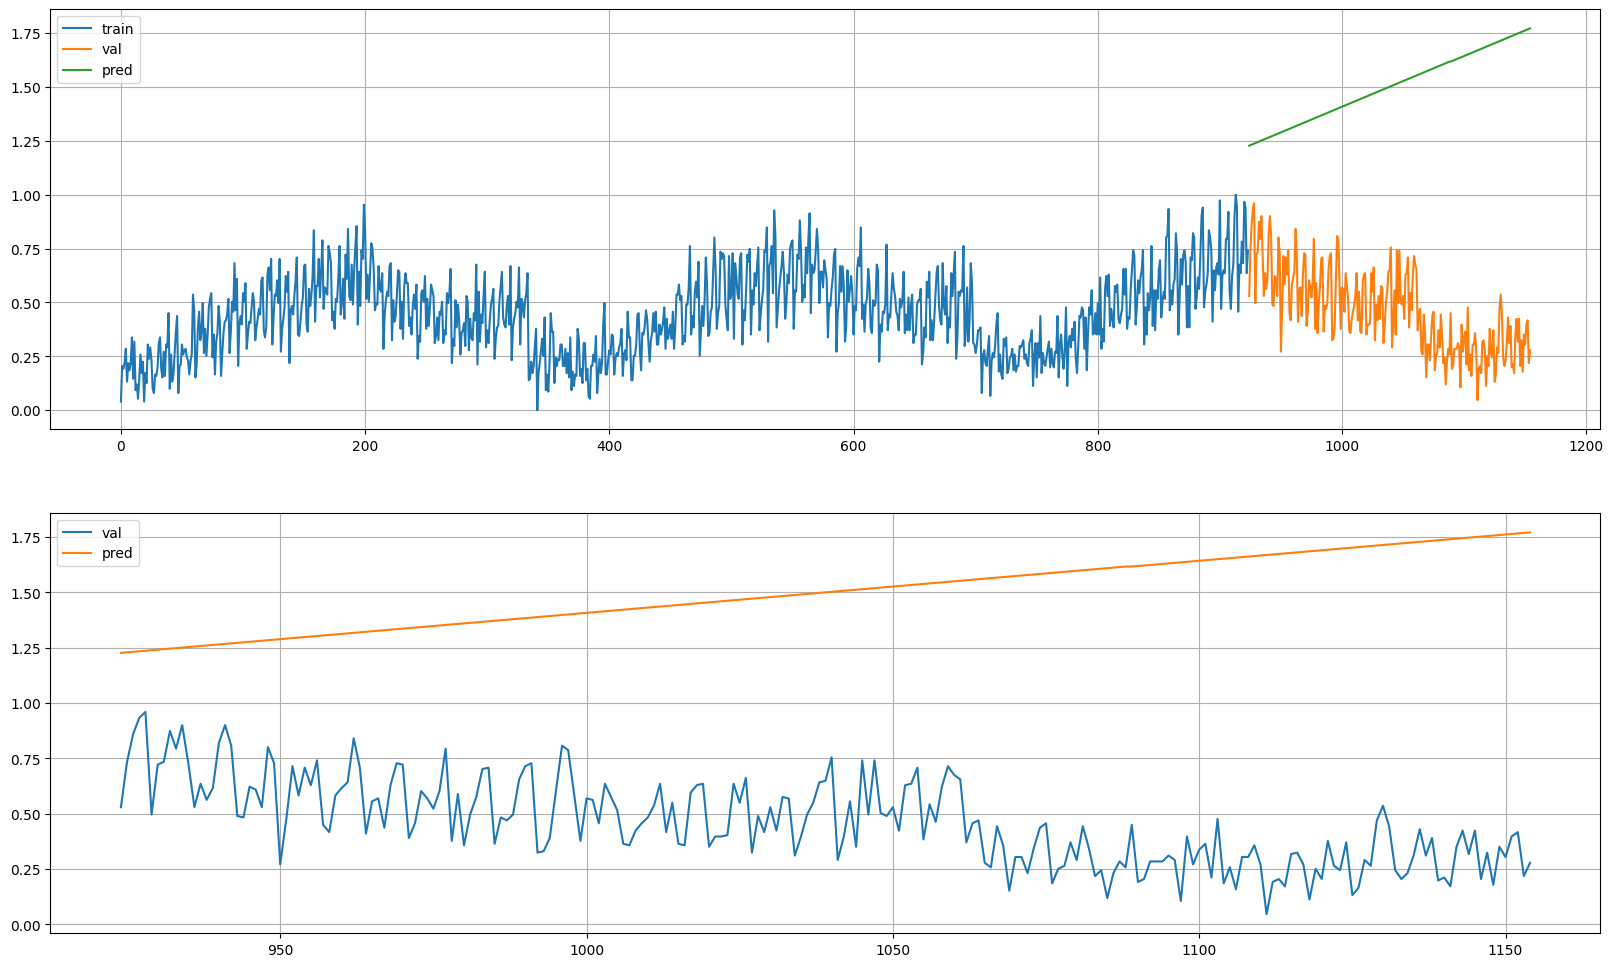

In [ ]:
# 예측 결과 시각화
plot_model_result(y_train, y_val, pred_nn)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
def preproc3d(data, timesteps, y_scale = False) :
    x = data.drop(['Date','Date_2', 'target'], axis = 1)
    y = data.loc[:, 'target']

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x['Day'] = pd.Categorical(x['Day'] ,categories=range(1, 32),ordered=True)
    x = pd.get_dummies(x, columns = ['WeekDay','Month','Day'])
    col_names = list(x)


    # 스케일링
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max



In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(product03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1005, 7, 65), (120, 7, 65))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([LSTM(16, activation='tanh',input_shape = (ts, nfeat) ),
                         Dense(1)])
model03_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 16)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,265 (20.57 KB)

 Trainable params: 5,265 (20.57 KB)

 Non-trainable params: 0 (0.00 B)

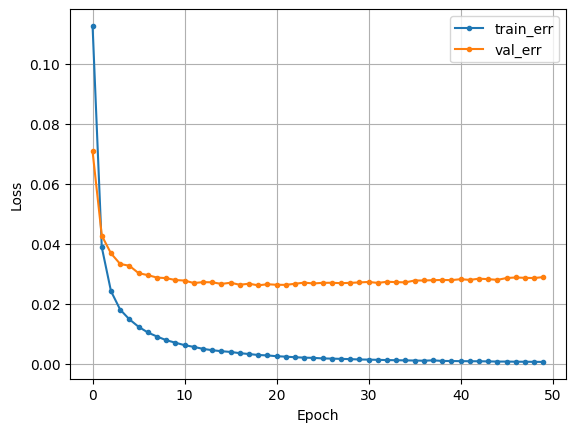

In [ ]:
model03_01.compile(optimizer = 'adam', loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
MAE :  2637.2232279459636
MAPE :  0.23356649682367464
R2 :  -0.0005742445404581797


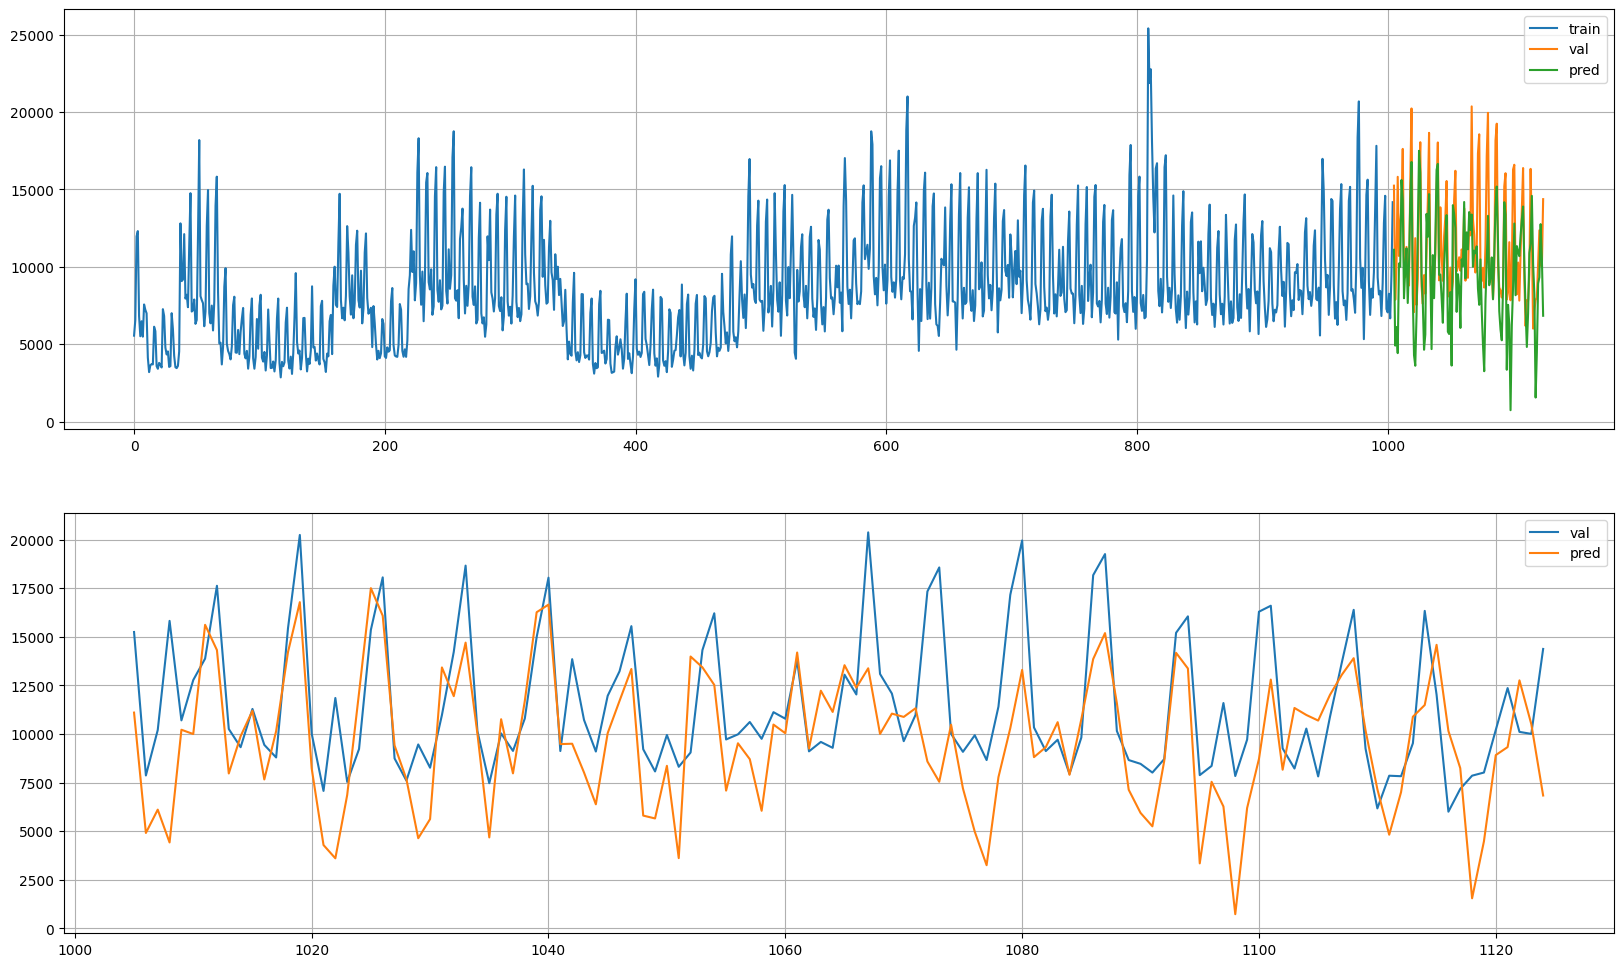

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
# 데이터 로드
n_x, n_y = temporalize(pd.DataFrame(x), y, 7)

In [ ]:
x_train_n, x_valid_n, y_train_n, y_valid_n = train_test_split(n_x, n_y, test_size=60, random_state=42, shuffle=False)

* **모델링**

In [ ]:
model_lstm = Sequential([Input(shape=(x_train_n.shape[1], x_train_n.shape[2])),
                         LSTM(4),
                         Dense(1)])

model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181 (724.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
hist2 = model_lstm.fit(x_train_n, y_train_n, validation_split=0.2, epochs=50, verbose=0).history

In [ ]:
y_pred_lstm = model_lstm.predict(x_valid_n)
y_pred_lstm = y_pred_lstm * (y_max - y_min) + y_min

y_valid_n2 = y_valid_n * (y_max - y_min) + y_min

print('RMSE:', root_mean_squared_error(y_valid_n2, y_pred_lstm))
print('MAE:', mean_absolute_error(y_valid_n2, y_pred_lstm))
print('MAPE:', mean_absolute_percentage_error(y_valid_n2, y_pred_lstm))
print('R2:', r2_score(y_valid_n2, y_pred_lstm))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
RMSE: 2112.7970715075976
MAE: 1585.5049397786458
MAPE: 0.12972977411220116
R2: 0.560891152850666


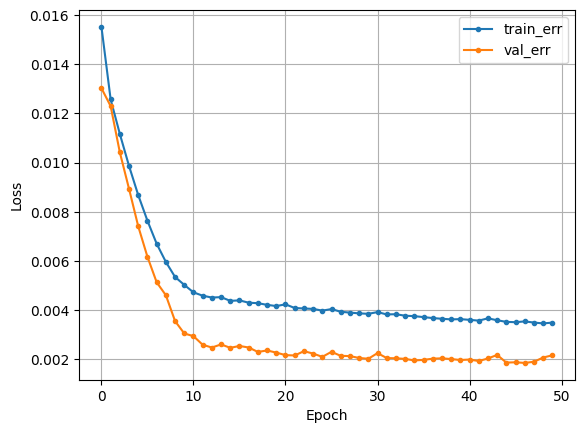

In [ ]:
dl_history_plot(hist2)

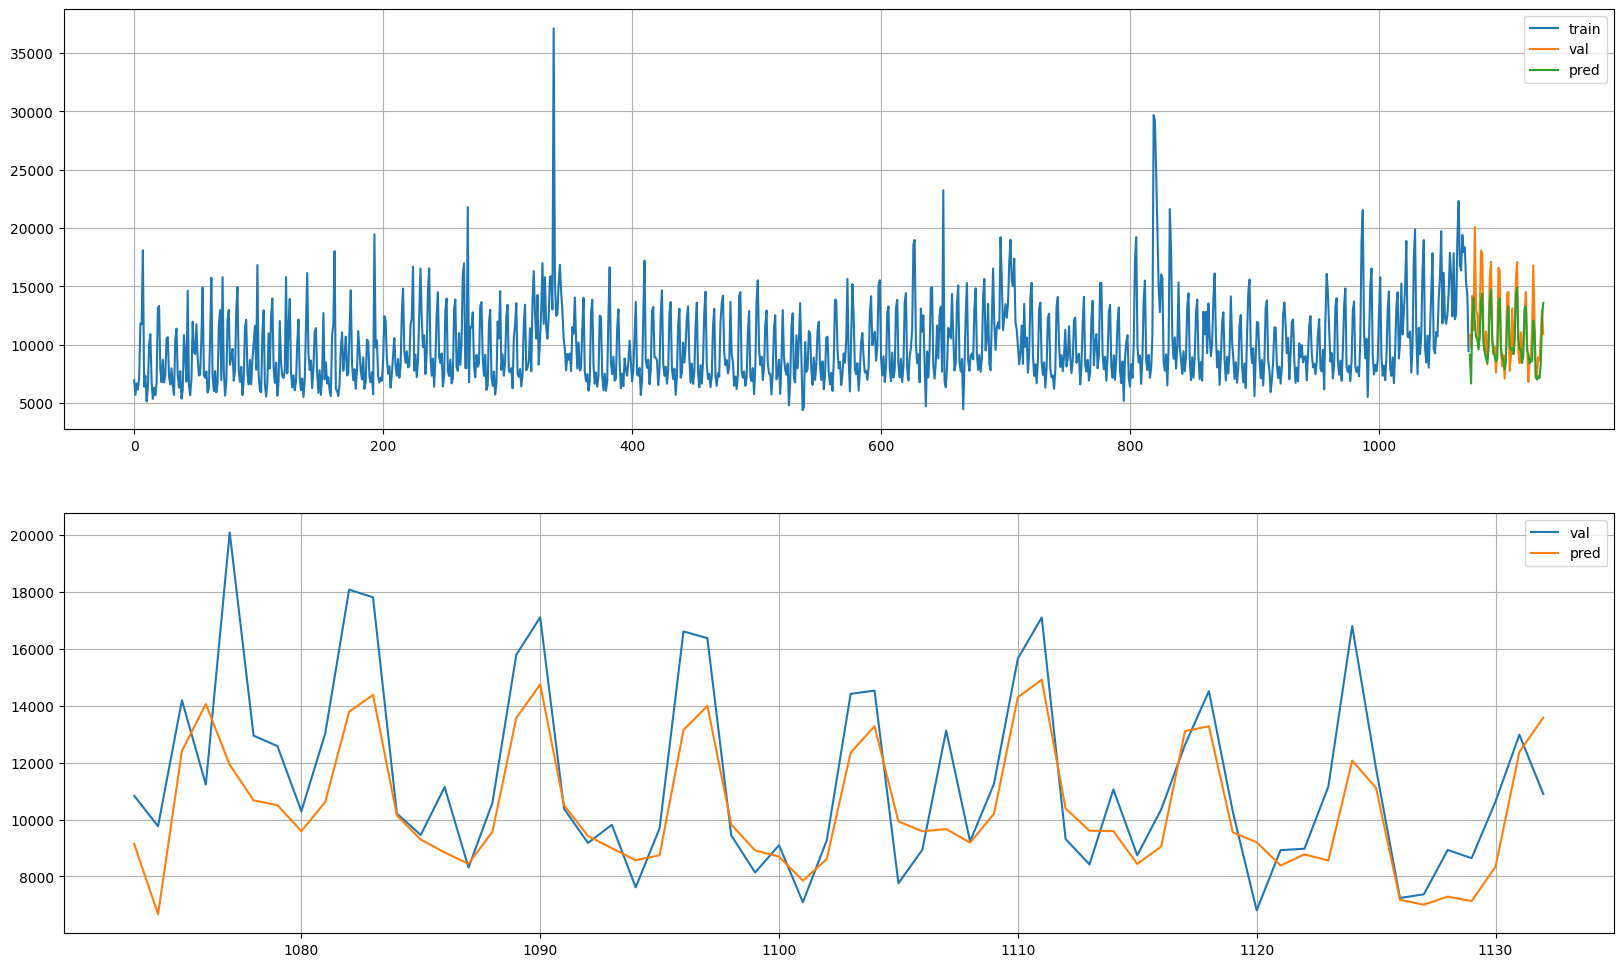

In [ ]:
y_train_n2 = y_train_n * (y_max - y_min) + y_min

plot_model_result(y_train_n2, y_valid_n2, y_pred_lstm)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
# ap_data = joblib.load(path + 'FM001_store44_dataset.pkl')  # 매장 44의 Agricultural products 데이터

# scaler = MinMaxScaler()
# ap_data['Qty_scaled'] = scaler.fit_transform(ap_data[['Qty']])
# 위에서 실행하였기에 주석처리함

In [ ]:
# timestep 10으로 설정
timestep=10
x,y = temporalize(ap_data[['Qty_scaled']],ap_data['Qty_scaled'],timestep)

# 학습 및 검증 데이터 분할(8:2)
train_size3 = int(len(x)*0.8)
x_train3,x_val3 = x[:train_size],x[train_size:]
y_train3,y_val3 = y[:train_size],y[train_size:]

* **모델링**

In [ ]:
clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(x_train3.shape[1],x_train3.shape[2]),
                    return_sequences=True))

model_lstm.add(LSTM(50,return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())

model_lstm.add(LSTM(50,return_sequences=False))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(25,activation='relu'))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam',loss='mean_squared_error')

hist3 = model_lstm.fit(x_train3,y_train3,epochs=100,batch_size=16,validation_data=(x_val3,y_val3),verbose=0)


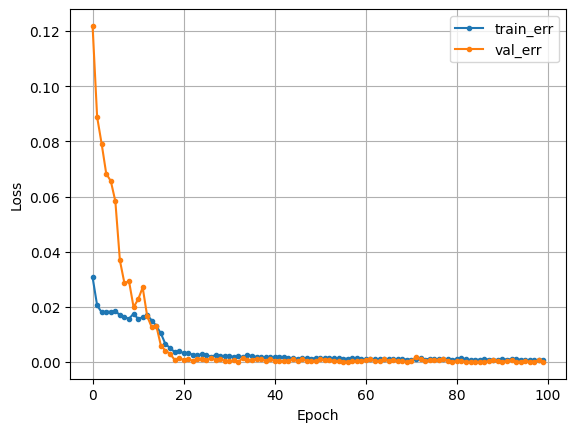

In [ ]:
dl_history_plot(hist3.history)

In [ ]:
pred_lstm = model_lstm.predict(x_val3)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


In [ ]:
# 평가지표를 찍기위한 역 스케일링
y_val_act = scaler.inverse_transform(y_val3.reshape(-1,1))
pred_act = scaler.inverse_transform(pred_lstm)

# 평가 지표 계산
rmse = mean_squared_error(y_val_act,pred_act,squared=False)
mae = mean_absolute_error(y_val_act,pred_act)
non_zero_idx = y_val_act != 0
mape = np.mean(np.abs((y_val_act - pred_act) / y_val_act)) * 100
r2 = r2_score(y_val_act,pred_act)

print(f"LSTM Model - RMSE:{rmse} / MAE:{mae} / MAPE:{mape}% / R2-Score:{r2}")

LSTM Model - RMSE:1.2778916457334928 / MAE:0.9991760253906243 / MAPE:1.0144245268137042% / R2-Score:0.9978275712128449


- RMSE (Root Mean Squared Error): 2.62로, 모델의 예측 오차가 낮음
- MAE (Mean Absolute Error): 2.15로, 모델의 절대 오차가 적어 실제 값과 예측 값의 차이가 크지 않음을 보여줌.
- MAPE (Mean Absolute Percentage Error): 약 1.98%로, 예측 값이 실제 값에 매우 가까운 수준임을 의미함
- R2 Score: 0.99로, 거의 1에 가까운 값을 가지므로 모델이 데이터를 매우 잘 설명하고 있음을 나타냄


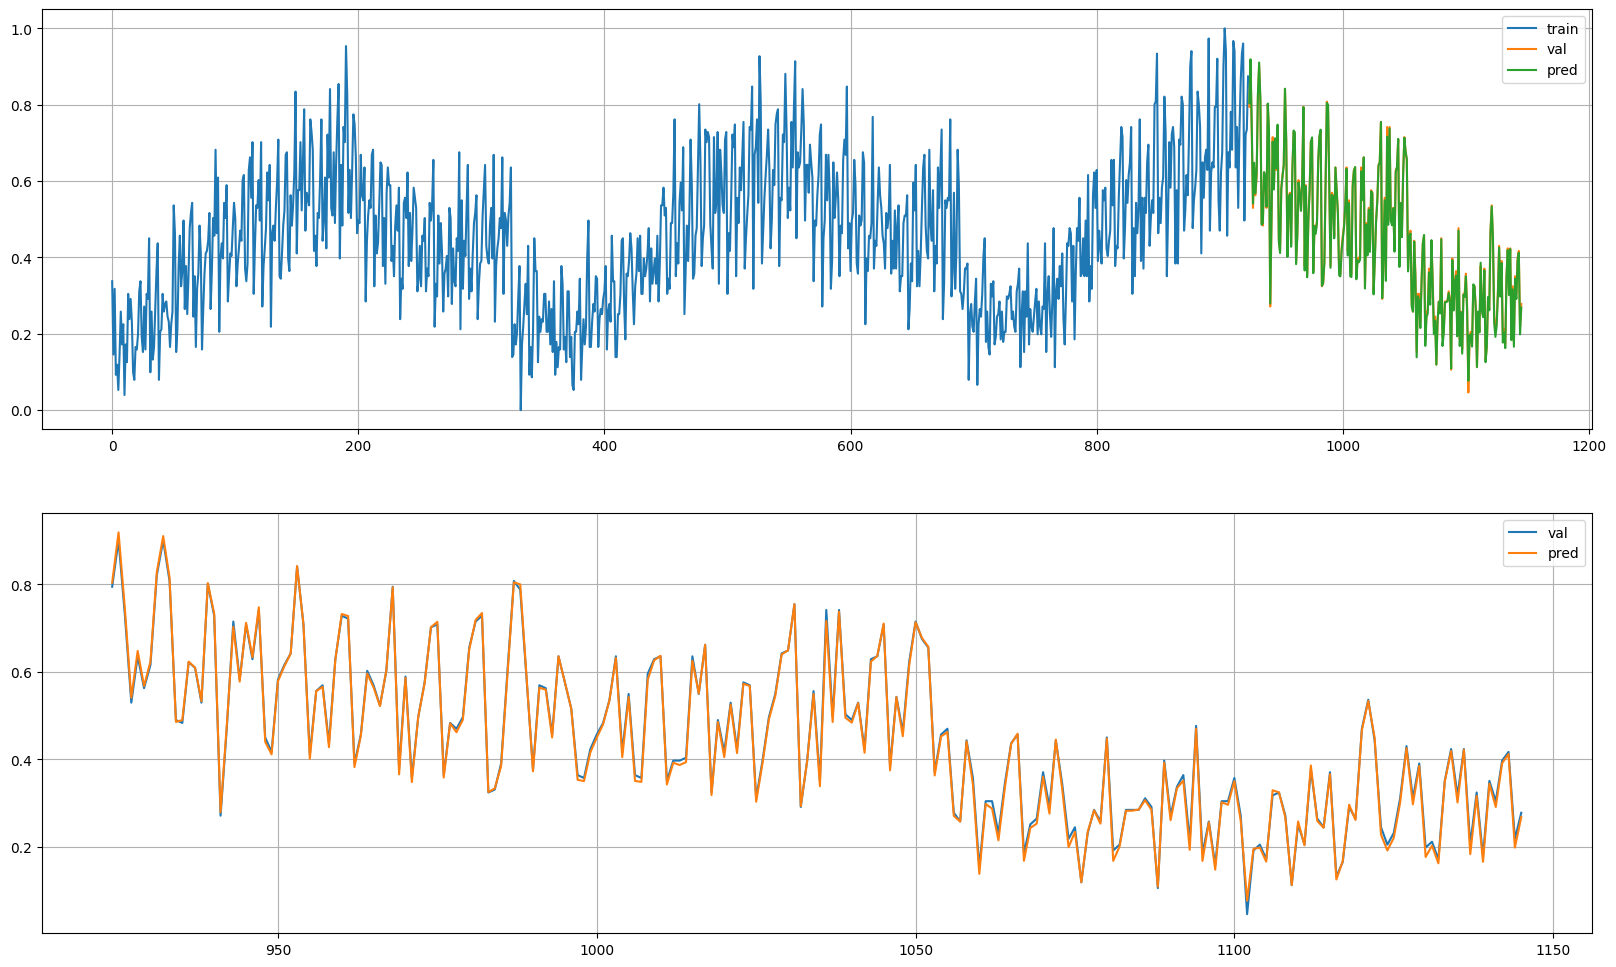

In [ ]:
plot_model_result(y_train3,y_val3,pred_lstm)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(product03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1005, 7, 65), (120, 7, 65))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model03_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 4)                │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 813 (3.18 KB)

 Trainable params: 813 (3.18 KB)

 Non-trainable params: 0 (0.00 B)

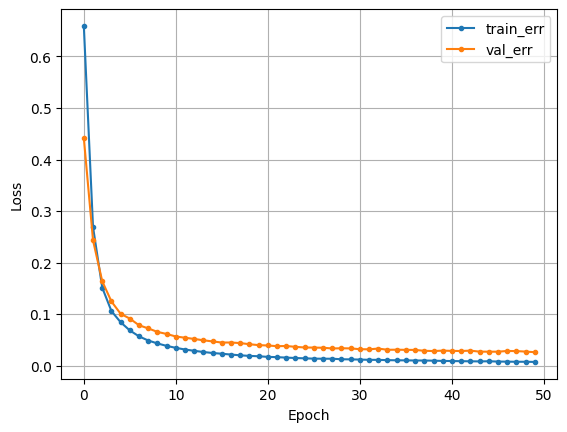

In [ ]:
model03_01.compile(optimizer = 'adam', loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
MAE :  3473.3749837239584
MAPE :  0.31073225500263685
R2 :  -0.5409499562049005


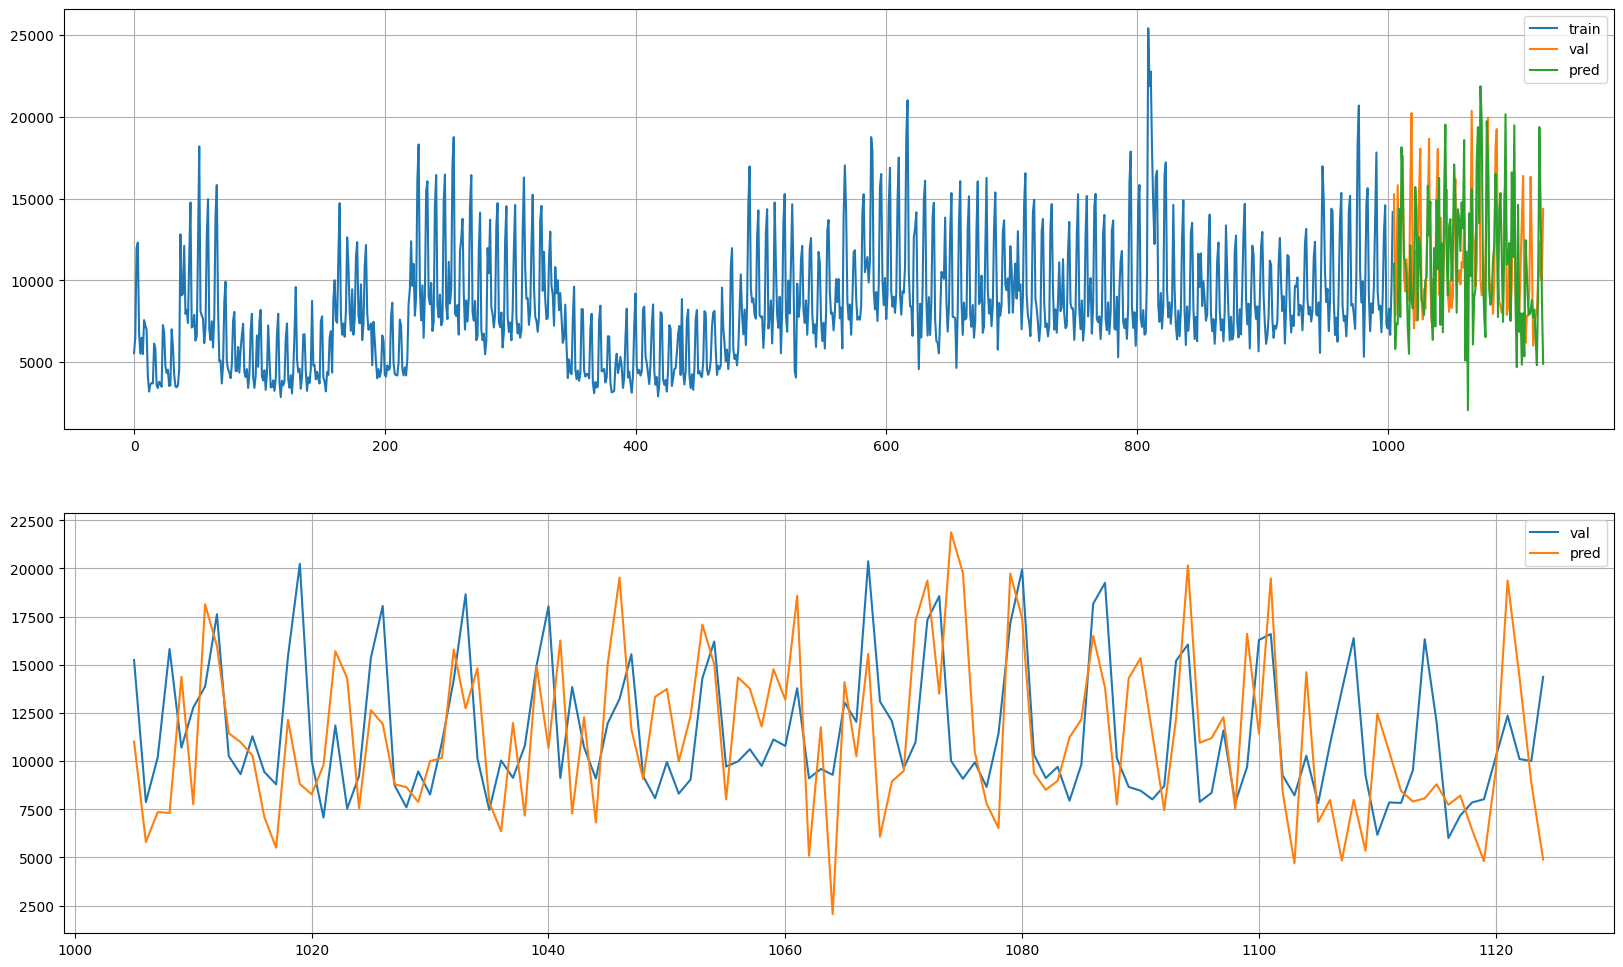

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
#위와 동일

* **모델링**

In [ ]:
model_cnn = Sequential([Input(shape=(x_train_n.shape[1], x_train_n.shape[2])),
                         Conv1D(4, 3, 1, 'same', activation='relu'),
                         Flatten(),
                         Dense(1)])

model_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 7, 4)                │              76 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105 (420.00 B)

 Trainable params: 105 (420.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cnn.compile(optimizer='adam', loss='mse')

In [ ]:
hist3 = model_cnn.fit(x_train_n, y_train_n, validation_split=0.2, epochs=50, verbose=0).history

In [ ]:
y_pred_cnn = model_cnn.predict(x_valid_n)
y_pred_cnn = y_pred_cnn * (y_max - y_min) + y_min

print('RMSE:', root_mean_squared_error(y_valid_n2, y_pred_cnn))
print('MAE:', mean_absolute_error(y_valid_n2, y_pred_cnn))
print('MAPE:', mean_absolute_percentage_error(y_valid_n2, y_pred_cnn))
print('R2:', r2_score(y_valid_n2, y_pred_cnn))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
RMSE: 1109.2849227755937
MAE: 821.4453694661458
MAPE: 0.07697845954672873
R2: 0.8789561203121691


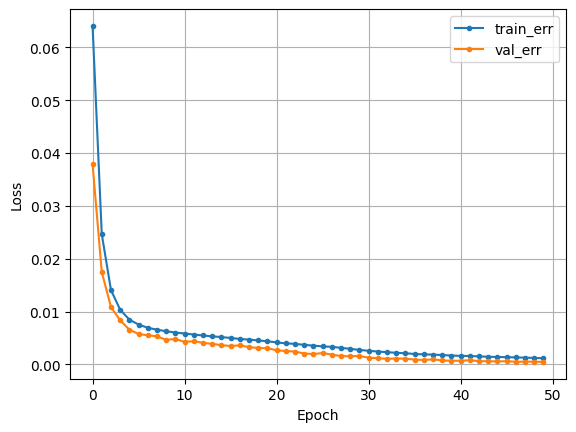

In [ ]:
dl_history_plot(hist3)

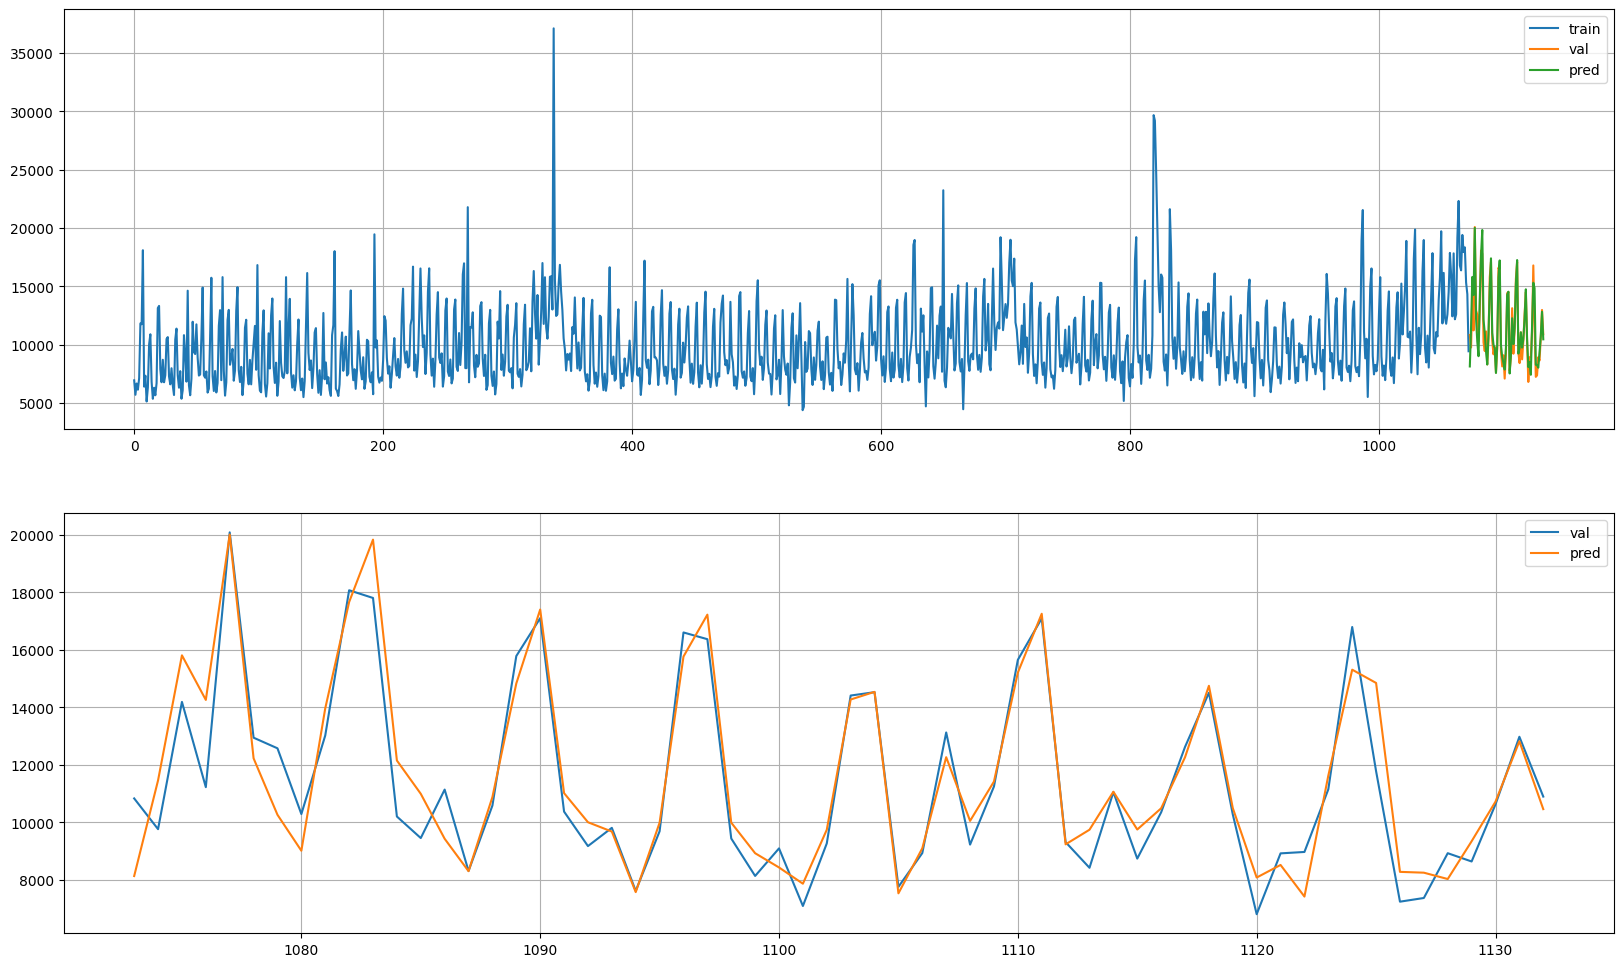

In [ ]:
plot_model_result(y_train_n2, y_valid_n2, y_pred_cnn)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
# ap_data = joblib.load(path + 'FM001_store44_dataset.pkl')  # 매장 44의 Agricultural products 데이터

# scaler = MinMaxScaler()
# ap_data['Qty_scaled'] = scaler.fit_transform(ap_data[['Qty']])
# 위에서 실행하였기에 주석처리함

In [ ]:
# timestep 10으로 설정
# timestep=10
# x,y = temporalize(ap_data[['Qty_scaled']],ap_data['Qty_scaled'],timestep)

# 학습 및 검증 데이터 분할(8:2)
# train_size2 = int(len(x)*0.8)
# x_train2,x_val2 = x[:train_size],x[train_size:]
# y_train2,y_val2 = y[:train_size],y[train_size:]

* **모델링**

In [ ]:
model_cnn3 = Sequential()

model_cnn3.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                     input_shape=(x_train3.shape[1], x_train3.shape[2])))
model_cnn3.add(MaxPooling1D(pool_size=2))
model_cnn3.add(BatchNormalization())

model_cnn3.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model_cnn3.add(MaxPooling1D(pool_size=2))
model_cnn3.add(BatchNormalization())

model_cnn3.add(Dropout(0.2))

model_cnn3.add(Flatten())
model_cnn3.add(Dense(50, activation='relu'))
model_cnn3.add(Dense(1))

model_cnn3.compile(optimizer='adam', loss='mean_squared_error')

hist_cnn3 = model_cnn3.fit(x_train3, y_train3, epochs=100, batch_size=16, validation_data=(x_val3, y_val3), verbose=0)


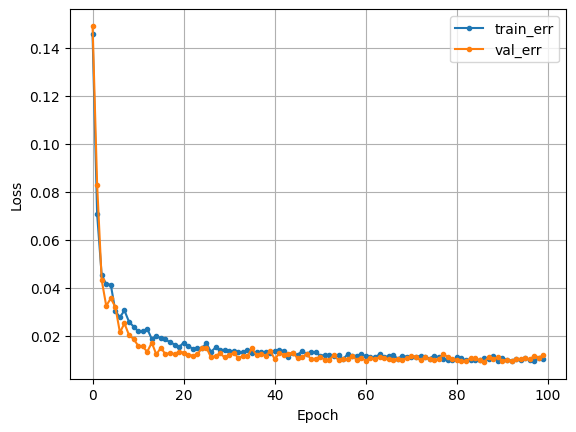

In [ ]:
dl_history_plot(hist_cnn3.history)

In [ ]:
pred_cnn3 = model_cnn3.predict(x_val3)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [ ]:
# y_val3와 pred_cnn3을 4개의 피처로 확장하여 역 스케일링 수행
# y_val3는 target 값만 있으므로 다른 피처 값은 0으로 채워줌
y_val3_expanded = np.zeros((y_val3.shape[0], 4))
y_val3_expanded[:, 0] = y_val3  # 첫 번째 열에 y_val3 값을 넣고 나머지는 0으로 채움

pred_cnn3_expanded = np.zeros((pred_cnn3.shape[0], 4))
pred_cnn3_expanded[:, 0] = pred_cnn3.flatten()  # 첫 번째 열에 pred_cnn3 값을 넣고 나머지는 0으로 채움

# 역 스케일링
y_val_act3 = scaler.inverse_transform(y_val3_expanded)[:, 0]  # 첫 번째 열만 사용
pred_act3 = scaler.inverse_transform(pred_cnn3_expanded)[:, 0]

# 평가 지표 계산
rmse = mean_squared_error(y_val_act3, pred_act3, squared=False)
mae = mean_absolute_error(y_val_act3, pred_act3)
non_zero_idx = y_val_act3 != 0
mape = np.mean(np.abs((y_val_act3[non_zero_idx] - pred_act3[non_zero_idx]) / y_val_act3[non_zero_idx])) * 100
r2 = r2_score(y_val_act3, pred_act3)

print(f"CNN Model - RMSE: {rmse} / MAE: {mae} / MAPE: {mape}% / R2-Score: {r2}")


CNN Model - RMSE: 16.44864408002932 / MAE: 12.873621883156062 / MAPE: 11.299126734277568% / R2-Score: 0.6400702921864994


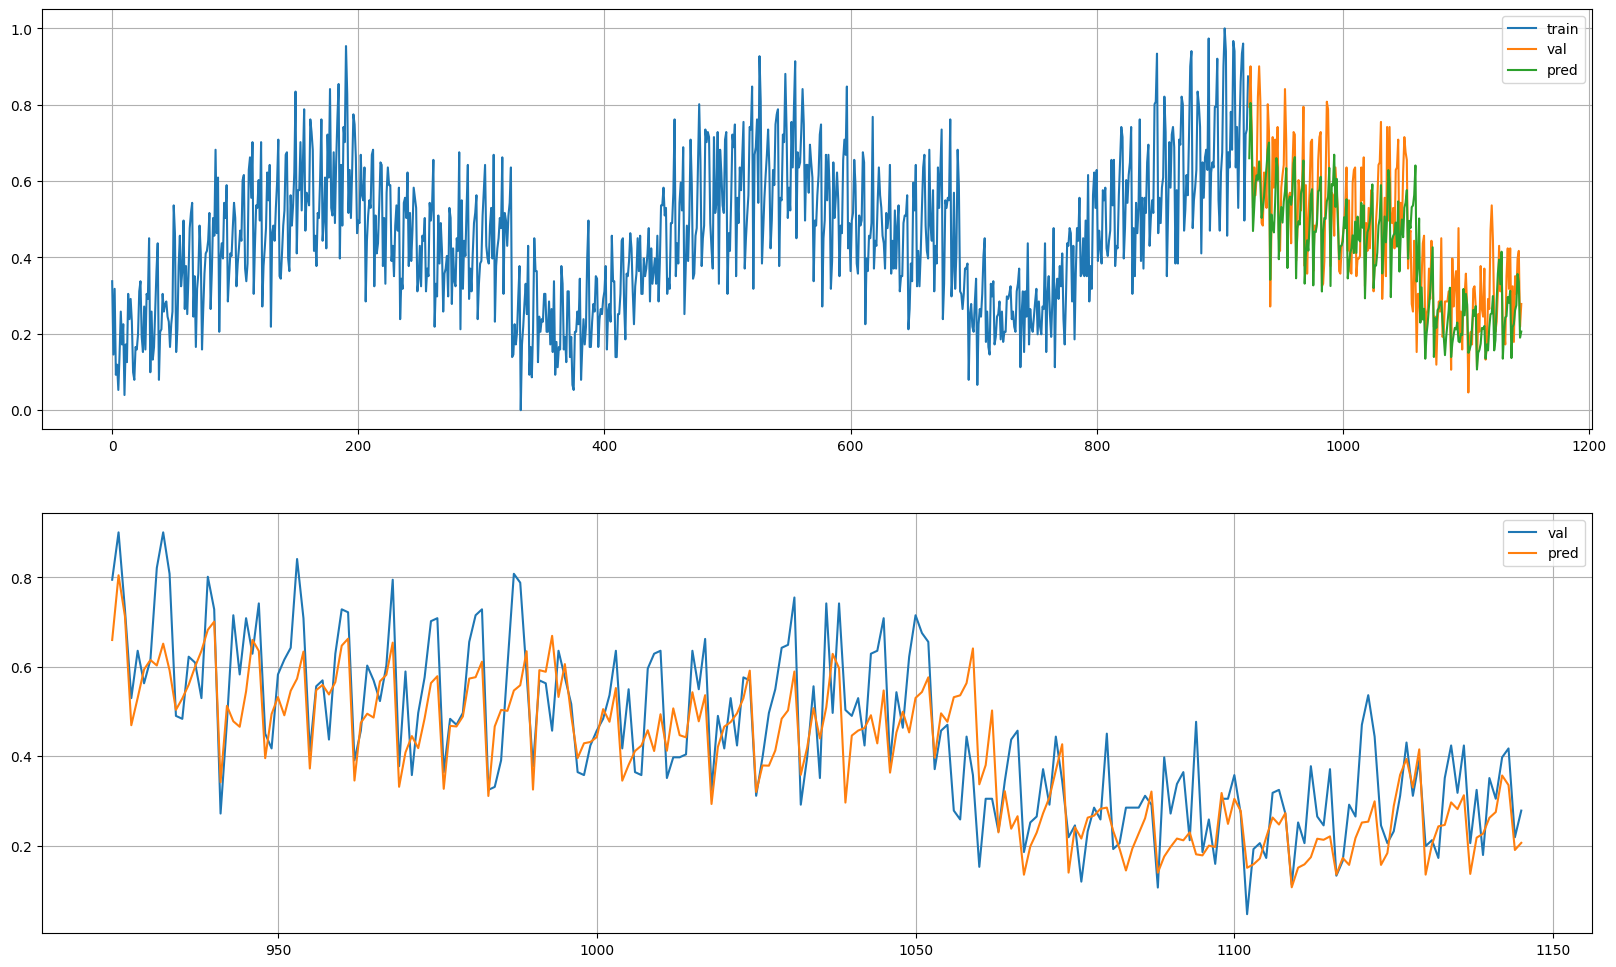

In [ ]:
plot_model_result(y_train3,y_val3,pred_cnn3)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
import joblib

joblib.dump(product03, path + 'data03.pkl')
# joblib.dump(data12, path + 'data12.pkl')
# joblib.dump(data42, path + 'data42.pkl')

['/content/drive/MyDrive/kt/projects_kt/project_6/6/data03.pkl']

In [ ]:
joblib.dump(target_sales_data, path + 'data12.pkl')

['/content/drive/MyDrive/kt/projects_kt/project_6/6/data12.pkl']

In [ ]:
joblib.dump(agricultural_data, path + f'{target_product_id}_store44_dataset.pkl')
print(f"Agricultural products (Product_ID: {target_product_id}, Store 44) 데이터셋이 저장되었습니다.")


Agricultural products (Product_ID: 42, Store 44) 데이터셋이 저장되었습니다.
